# Perovskites

In this notebook, we demonstrate some of the initial work on this project that was carried out in the summer of 2021. Here, we leverage some Xenonpy-calculated properties to calculate the unit cell volume of several perovskite systems taken from NOMAD's database.

Both SISSO and TPOT are used to train predictive models, and near the end of the document we discuss what we can learn from this comparison.

Overall, in this notebook we demonstrate SISSO's ability to generate simple, interpretable models that can help lead us to physical insight - one of the major strengths of symbolic regression.

In [1]:
import functools
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tpot
import sklearn
import optuna
import xgboost

import xenonpy.descriptor

import sys

sys.path.append("../../../")
import DigitalEcosystem.utils.figures

from IPython.display import Latex

pd.options.mode.chained_assignment = None 

In [2]:
# Random seeds for reproducibility
RANDOM_SEED = 1234
import random
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Read in the Data

Read the data, and featurize using XenonPy

In [3]:
data = pd.read_pickle('../../raw_data/perovskites.pkl')

# Scale volume to have units of Å^3 / formula unit
data["Volume"] /= data["Atoms_Object"].apply(lambda atoms: len(atoms)//5)

# Featurize with XenonPy
cal = xenonpy.descriptor.Compositions()
data["Symbols"] = data.Atoms_Object.apply(lambda atoms: collections.Counter(atoms.get_chemical_symbols()))
featurized_data = pd.concat([data, cal.transform(data.Symbols)], axis=1)

data = featurized_data.drop(columns=['Symbols'])
data

,Formula,Atoms_Object,Volume,ave:atomic_number,ave:atomic_radius,ave:atomic_radius_rahm,ave:atomic_volume,ave:atomic_weight,ave:boiling_point,ave:bulk_modulus,...,min:num_s_valence,min:period,min:specific_heat,min:thermal_conductivity,min:vdw_radius,min:vdw_radius_alvarez,min:vdw_radius_mm3,min:vdw_radius_uff,min:sound_velocity,min:Polarizability
0,AgCl3K,"(Atom('K', [2.546784180928994, 2.5467841809289...",132.452162,23.4,164.212290,215.4,22.340,50.663300,849.560,21.280000,...,1.0,3.0,0.237,0.00890,175.0,182.0,207.0,314.8,206.0,2.180
1,La2N6W2,"(Atom('La', [2.665318694121161, 2.857224133724...",65.894295,30.4,120.800000,214.8,16.786,72.953294,1978.440,102.018930,...,2.0,2.0,0.133,0.02583,155.0,166.0,193.0,309.6,333.6,1.100
2,O3SrV,"(Atom('Sr', [1.9322684339857643, 1.93226843398...",57.715487,17.0,157.520852,208.8,16.810,37.311700,1115.514,92.159719,...,2.0,2.0,0.301,0.02658,152.0,150.0,182.0,314.4,317.5,0.802
3,Cl6Cs2Tl2,"(Atom('Cs', [7.926562986915786, 0.0, 0.0289390...",176.625755,37.4,176.012290,221.8,28.660,88.727090,679.480,9.580000,...,1.0,3.0,0.128,0.00890,175.0,182.0,207.0,394.7,206.0,2.180
4,F3MnRb,"(Atom('Rb', [2.1409860345006186, 2.14098603450...",78.511177,17.8,157.014169,194.2,22.918,39.480211,690.206,52.579364,...,1.0,2.0,0.360,0.02770,147.0,146.0,171.0,296.1,1300.0,0.557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,F6In2Mn2,"(Atom('In', [3.004706503626541, 3.051648750812...",77.734000,20.2,140.614169,195.4,14.878,45.350251,968.606,67.917949,...,2.0,2.0,0.234,0.02770,147.0,146.0,171.0,296.1,1215.0,0.557
140,CaF3Rb,"(Atom('Rb', [2.259732663194181, 2.259732663194...",92.312641,16.8,169.414169,199.8,27.420,36.508202,594.606,31.979364,...,1.0,2.0,0.360,0.02770,147.0,146.0,171.0,336.4,1300.0,0.557
141,MoNaO3,"(Atom('Na', [0.0, 0.0, 0.0], index=0), Atom('M...",59.086370,15.4,153.520852,196.4,15.020,33.387354,1262.334,92.923625,...,1.0,2.0,0.251,0.02658,152.0,150.0,182.0,298.3,317.5,0.802
142,KO3W,"(Atom('K', [0.0, 0.0, 0.0], index=0), Atom('W'...",62.178694,23.4,162.920852,200.0,19.366,54.187060,1449.514,108.283625,...,1.0,2.0,0.133,0.02658,152.0,150.0,182.0,309.6,317.5,0.802


# Prepare Data

In [4]:
target_column = ['Volume']
xenonpy_descriptors = [col for col in data.columns if ":" in col]

train, test = sklearn.model_selection.train_test_split(data, test_size=0.1, random_state=RANDOM_SEED)

train_x = train[xenonpy_descriptors].to_numpy()
train_y = train[target_column].to_numpy()

test_x = test[xenonpy_descriptors].to_numpy()
test_y = test[target_column].to_numpy()

In [5]:
def rmse(y_true, y_pred):
    mse = sklearn.metrics.mean_squared_error(y_true=y_true, y_pred=y_pred)
    rmse = np.sqrt(abs(mse))
    return rmse

metrics = {
    'MaxError': sklearn.metrics.max_error,
    'MAE': sklearn.metrics.mean_absolute_error,
    'MSE': sklearn.metrics.mean_squared_error,
    'RMSE': rmse,
    'MAPE': sklearn.metrics.mean_absolute_percentage_error,
    'R2': sklearn.metrics.r2_score
}

# XGBoost

In [6]:
current_reg = None
best_reg = None
def keep_best_reg(study, trial):
    global best_reg
    if study.best_trial == trial:
        best_reg = current_reg

objective_train_x_reg, objective_validation_x_reg, objective_train_y_reg, objective_validation_y_reg = sklearn.model_selection.train_test_split(
    np.nan_to_num(train_x), train_y, test_size=0.2, random_state=RANDOM_SEED)

def objective(trial: optuna.Trial):
    global current_reg


    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0, 1),
        'min_split_loss': trial.suggest_float('min_split_loss', 0, 1),
        'max_depth': trial.suggest_int('max_depth', 1, 100),
        'min_child_weight': trial.suggest_float('min_child_weight', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 2),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 2)
    }
    
    scalers = {
        "StandardScaler": sklearn.preprocessing.StandardScaler(),
        "MinMaxScaler": sklearn.preprocessing.MinMaxScaler()
    }

    scaler = trial.suggest_categorical('scaler', scalers.keys())

    current_reg = sklearn.pipeline.Pipeline([
        (scaler, scalers[scaler]),
        ("XGB_Regressor", xgboost.sklearn.XGBRegressor(**params,
                                               n_estimators=100,
                                               n_jobs=1,
                                               objective='reg:squarederror',
                                               random_state=RANDOM_SEED),)
    ])

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, f'validation_0-rmse')
    current_reg.fit(X=objective_train_x_reg, y=objective_train_y_reg,
                         **{
                            'XGB_Regressor__eval_set': [[objective_validation_x_reg, objective_validation_y_reg]],
                            'XGB_Regressor__eval_metric': 'rmse',
                            'XGB_Regressor__early_stopping_rounds': 50,
                            'XGB_Regressor__callbacks': [pruning_callback],
                            'XGB_Regressor__verbose': False
                         })

    score = sklearn.metrics.mean_poisson_deviance(
        y_true=objective_validation_y_reg,
        y_pred=abs(current_reg.predict(objective_validation_x_reg)),
    )

    return score

reg_study = optuna.create_study(
    sampler = optuna.samplers.TPESampler(
        seed = RANDOM_SEED,
        warn_independent_sampling = True,
        consider_endpoints = True
    ),
    pruner = optuna.pruners.HyperbandPruner(
        min_resource=1,
        max_resource=100),
    direction='minimize')

reg_study.optimize(func=objective, n_trials=1000, callbacks=[keep_best_reg])

[I 2021-10-04 16:17:43,250] A new study created in memory with name: no-name-0e0e7568-ed5a-437b-80d1-10723df1b375
[I 2021-10-04 16:17:43,437] Trial 0 finished with value: 23.492229994546662 and parameters: {'learning_rate': 0.1915194503788923, 'min_split_loss': 0.6221087710398319, 'max_depth': 44, 'min_child_weight': 7.853585837137692, 'reg_lambda': 1.559951616237607, 'reg_alpha': 0.5451852105652832, 'scaler': 'MinMaxScaler'}. Best is trial 0 with value: 23.492229994546662.
[I 2021-10-04 16:17:43,630] Trial 1 finished with value: 4.967684075699349 and parameters: {'learning_rate': 0.9581393536837052, 'min_split_loss': 0.8759326347420947, 'max_depth': 36, 'min_child_weight': 5.009951255234587, 'reg_lambda': 1.3669258703442726, 'reg_alpha': 1.4254040539658004, 'scaler': 'MinMaxScaler'}. Best is trial 1 with value: 4.967684075699349.
[I 2021-10-04 16:17:43,783] Trial 2 finished with value: 49.78365344055158 and parameters: {'learning_rate': 0.5030831653078097, 'min_split_loss': 0.01376844

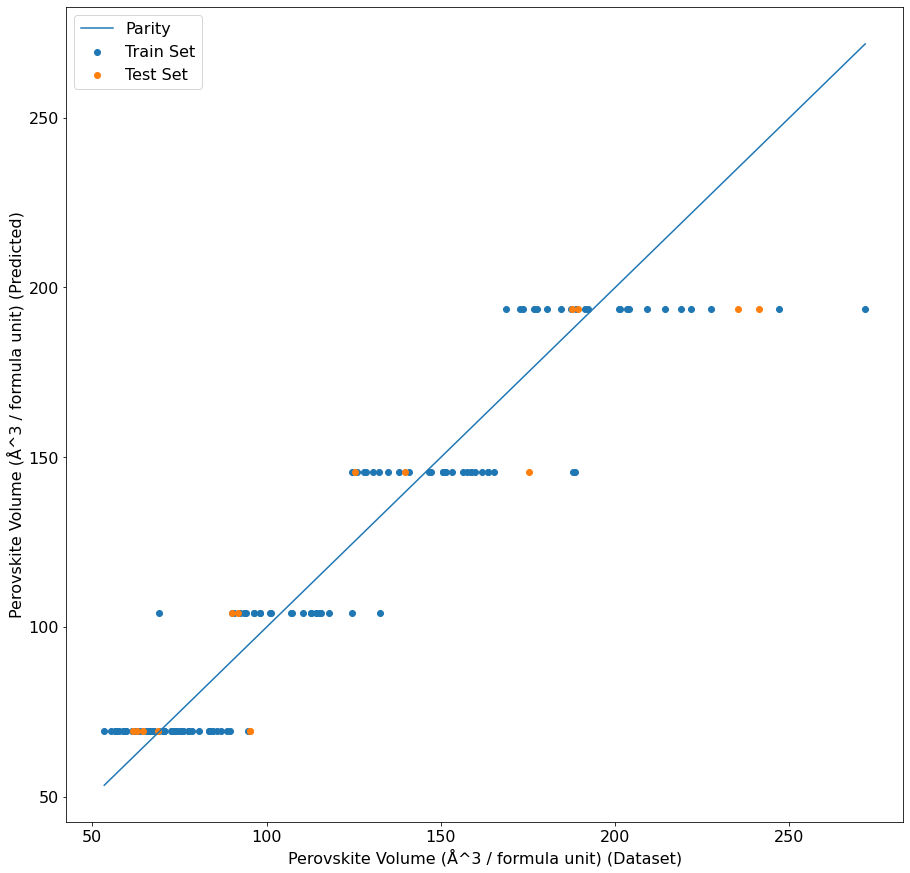

In [7]:
DigitalEcosystem.utils.figures.save_parity_plot(train_x,
                                                test_x,
                                                train_y,
                                                test_y,
                                                best_reg,
                                                "Perovskite Volume (Å^3 / formula unit)",
                                                "xgboost_perovskite_volume_parity.jpeg")

In [8]:
print("Test Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=test_y, y_pred=best_reg.predict(test_x))
    print(key,np.round(value,4))
    
print("\nTraining Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=train_y, y_pred=best_reg.predict(train_x))
    print(key,np.round(value,4))

Test Set Error Metrics
MaxError 47.698
MAE 16.8996
MSE 479.267
RMSE 21.8922
MAPE 0.1301
R2 0.8694

Training Set Error Metrics
MaxError 78.0454
MAE 11.6425
MSE 249.7033
RMSE 15.802
MAPE 0.1033
R2 0.9051


# TPOT

In [9]:
tpot_model = tpot.TPOTRegressor(
    generations=10,
    population_size=100,
    max_eval_time_mins=10 / 60,
    cv=10,
    verbosity=2,
    scoring="neg_root_mean_squared_error",
    config_dict=tpot.config.regressor_config_dict,
    n_jobs=-1,
    random_state=1234
)

tpot_model.fit(train_x, train_y.ravel())

Optimization Progress:   0%|          | 0/1100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -4.717022046092263

Generation 2 - Current best internal CV score: -4.717022046092263

Generation 3 - Current best internal CV score: -4.717022046092263

Generation 4 - Current best internal CV score: -4.5102759479159085

Generation 5 - Current best internal CV score: -4.5102759479159085

Generation 6 - Current best internal CV score: -4.5102759479159085

Generation 7 - Current best internal CV score: -4.5102759479159085

Generation 8 - Current best internal CV score: -4.5102759479159085

Generation 9 - Current best internal CV score: -4.5102759479159085

Generation 10 - Current best internal CV score: -4.441210252154802

Best pipeline: RidgeCV(StandardScaler(XGBRegressor(DecisionTreeRegressor(input_matrix, max_depth=2, min_samples_leaf=9, min_samples_split=19), learning_rate=0.5, max_depth=3, min_child_weight=15, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.1, verbosity=0)))


TPOTRegressor(config_dict={'sklearn.cluster.FeatureAgglomeration': {'affinity': ['euclidean',
                                                                                 'l1',
                                                                                 'l2',
                                                                                 'manhattan',
                                                                                 'cosine'],
                                                                    'linkage': ['ward',
                                                                                'complete',
                                                                                'average']},
                           'sklearn.decomposition.FastICA': {'tol': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])},
                           'sklearn.decomposition.PCA': {'iter

/Users/mat3ra/.pyenv/versions/3.8.6/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


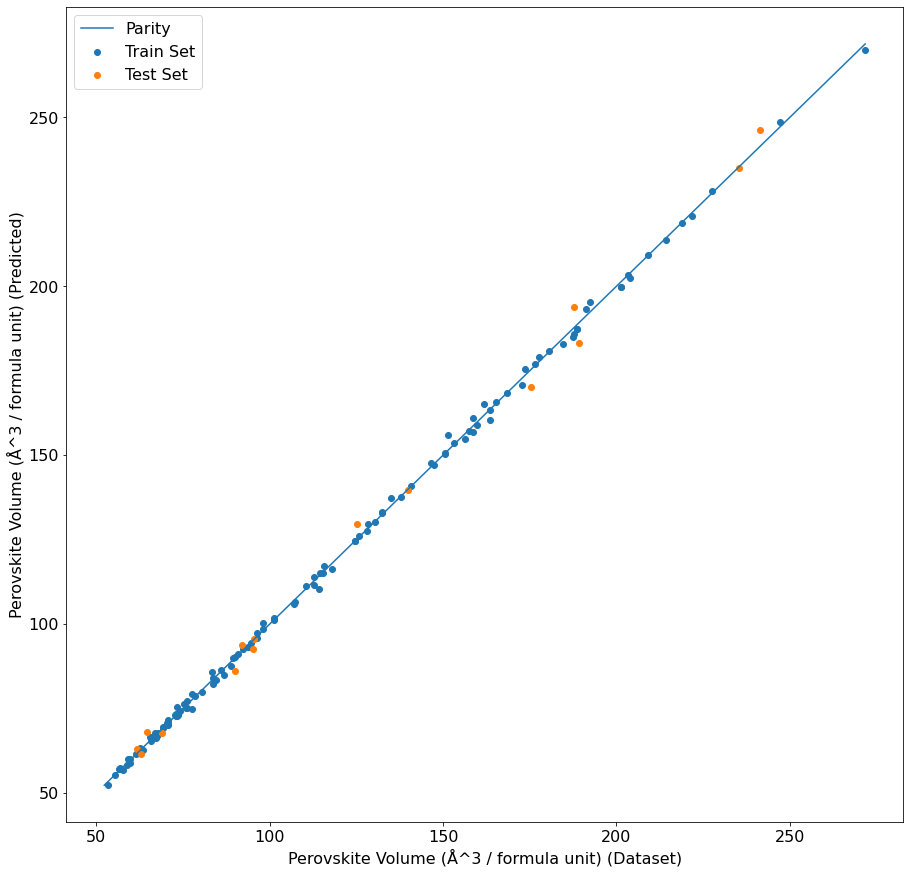

In [10]:
DigitalEcosystem.utils.figures.save_parity_plot(train_x,
                                                test_x,
                                                train_y,
                                                test_y,
                                                tpot_model,
                                                "Perovskite Volume (Å^3 / formula unit)",
                                                "tpot_perovskite_volume_parity.jpeg")

In [11]:
print("Test Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=test_y, y_pred=tpot_model.predict(test_x))
    print(key,np.round(value,4))
    
print("\nTraining Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=train_y, y_pred=tpot_model.predict(train_x))
    print(key,np.round(value,4))

Test Set Error Metrics
MaxError 6.1322
MAE 2.8771
MSE 12.3533
RMSE 3.5147
MAPE 0.0241
R2 0.9966

Training Set Error Metrics
MaxError 4.7387
MAE 0.9186
MSE 1.5725
RMSE 1.254
MAPE 0.0084
R2 0.9994


# Roost

In [12]:
import os
roost_dir = "./roost"
os.makedirs(roost_dir, exist_ok=True)

roost_data_train = train[['Formula', 'Volume']]
roost_data_test = test[['Formula', 'Volume']]

roost_data_train.to_csv(os.path.join(roost_dir, 'roost_train.csv'), index_label='material_id')
roost_data_test.to_csv(os.path.join(roost_dir, 'roost_test.csv'), index_label='material_id')

At this point, Roost models were run. Logs can be found in the Roost directory, along with the resultant predictions.

In [13]:
roost_train_results = pd.read_csv("roost/roost_train_predictions.csv", index_col="material_id")
roost_test_results  = pd.read_csv("roost/roost_test_predictions.csv", index_col="material_id")

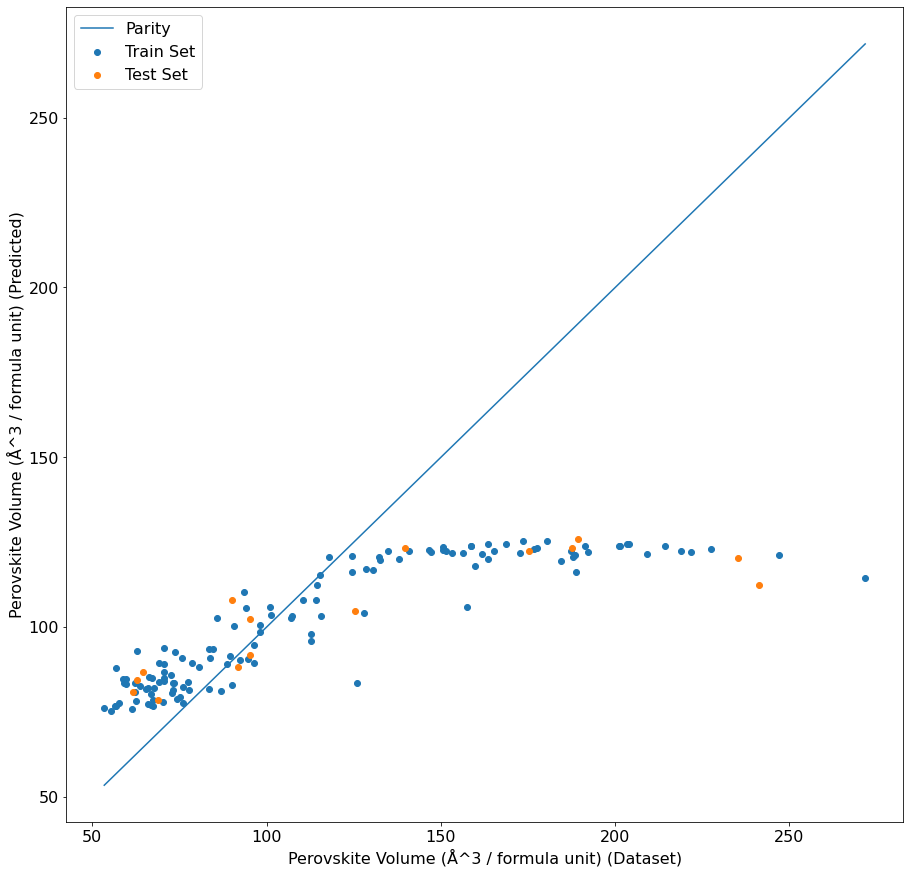

In [46]:
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
plt.rcParams["figure.figsize"] = (15, 15)
plt.rcParams["font.size"] = 16

plt.scatter(x=roost_train_results['volume_target'], y=roost_train_results['volume_pred_n0'], label="Train Set")
plt.scatter(x=roost_test_results['volume_target'], y=roost_test_results['volume_pred_n0'], label="Test Set")

min_xy = min(min(roost_train_results['volume_target']),
             min(roost_test_results['volume_target']),
             min(roost_train_results['volume_pred_n0']),
             min(roost_test_results['volume_pred_n0']))
max_xy = max(max(roost_train_results['volume_target']),
             max(roost_test_results['volume_target']),
             max(roost_train_results['volume_pred_n0']),
             max(roost_test_results['volume_pred_n0']))

plt.plot([min_xy, max_xy], [min_xy, max_xy], label="Parity")
plt.ylabel(f"Perovskite Volume (Å^3 / formula unit) (Predicted)")
plt.xlabel(f"Perovskite Volume (Å^3 / formula unit) (Dataset)")
plt.legend()
plt.savefig("roost_perovskite_volume_parity.jpeg")
plt.show()
plt.close()

In [15]:
print("Test Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=roost_test_results['volume_target'], y_pred=roost_test_results['volume_pred_n0'])
    print(key,np.round(value,4))
    
print("\nTraining Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=roost_train_results['volume_target'], y_pred=roost_train_results['volume_pred_n0'])
    print(key,np.round(value,4))

Test Set Error Metrics
MaxError 128.8481
MAE 37.749
MSE 2883.802
RMSE 53.701
MAPE 0.2515
R2 0.2143

Training Set Error Metrics
MaxError 157.1842
MAE 27.1005
MSE 1534.3937
RMSE 39.1713
MAPE 0.2119
R2 0.417


# SISSO

Start by obtaining importance scores from the XGBoost model

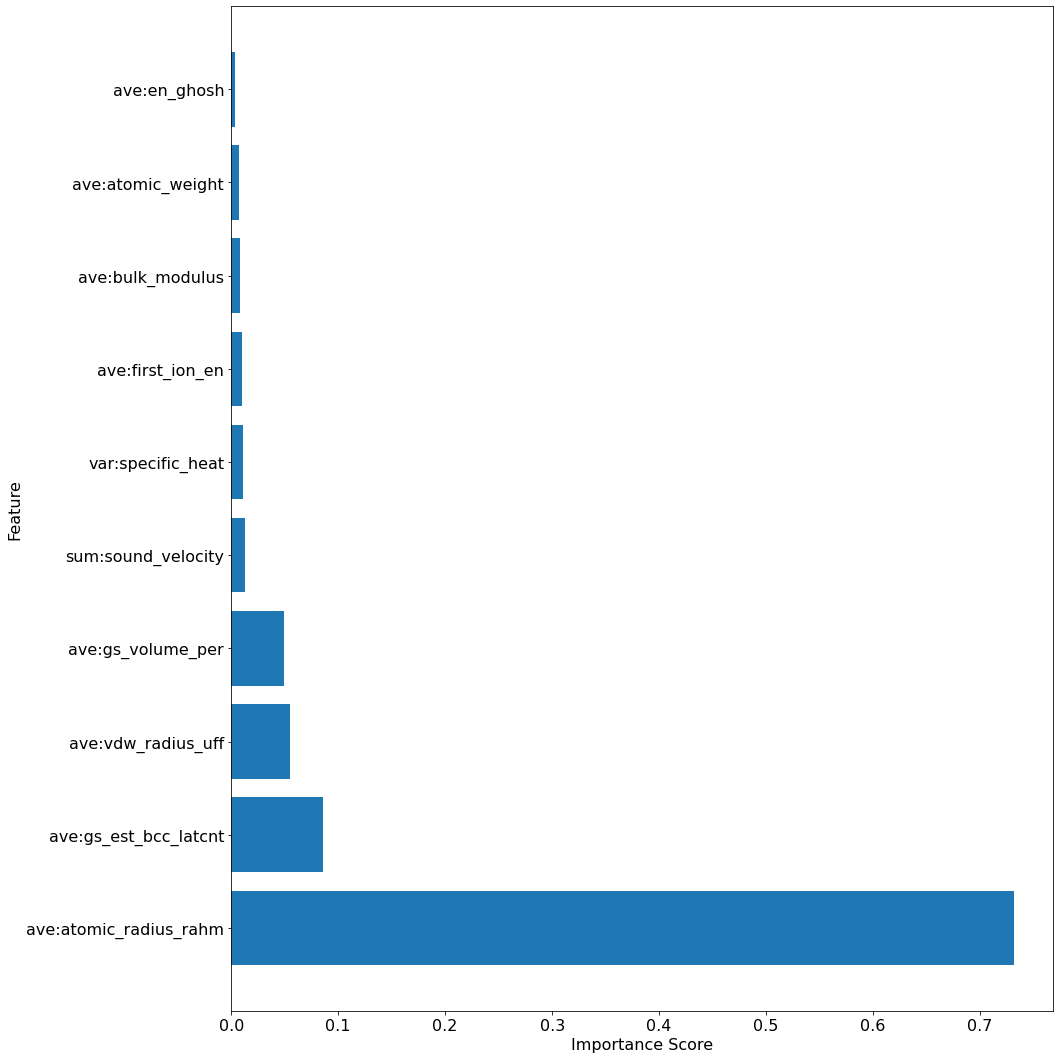

In [47]:
n_importances = 10
importances = list(zip(best_reg[1].feature_importances_, xenonpy_descriptors))

sorted_importances = list(sorted(importances, key=lambda i: -i[0]))
plt.barh(range(n_importances), [imp[0] for imp in sorted_importances[:n_importances]])
plt.yticks(range(n_importances), [imp[1] for imp in sorted_importances[:n_importances]])
plt.ylabel("Feature")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.savefig("xgboost_importances.jpeg")

In [17]:
important_features = [record[1] for record in sorted_importances[:n_importances]]

sisso_dir = "./sisso"
os.makedirs(sisso_dir, exist_ok=True)

sisso_data_train = train[target_column + important_features]
sisso_data_test = test[target_column + important_features]

sisso_data_train.to_csv(os.path.join(sisso_dir, 'sisso_train.csv'), index_label='material_id')

At this point, a SISSO model was run.

In [39]:
sisso_models = {
    'r1_1term': lambda df: -1.173401497819689e+02 + \
                           1.710176880247700e-01 * (df['ave:vdw_radius_uff'] * df['ave:gs_est_bcc_latcnt']),
    
    'r1_2term': lambda df: -7.912354154958560e+01 + \
                           -1.609923938541456e-02 * (df['ave:bulk_modulus'] * df['ave:gs_volume_per']) + \
                           1.559313572968614e-01 * (df['ave:vdw_radius_uff'] * df['ave:gs_est_bcc_latcnt']),
    
    'r1_3term': lambda df: -6.567261626600551e+01 + \
                           -2.978198018981838e+01 * (df['ave:gs_volume_per'] / df['ave:atomic_weight']) + \
                           -1.704453039727385e-02 * (df['ave:bulk_modulus'] * df['ave:gs_volume_per']) + \
                           1.581938411940554e-01 * (df['ave:vdw_radius_uff'] * df['ave:gs_est_bcc_latcnt']),
    
    'r1_4term': lambda df: 3.301002567877740e+02 + \
                           -3.565682575738922e-01 * (df['ave:bulk_modulus'] + df['ave:gs_volume_per']) + \
                           3.786694583493326e-06 * (df['ave:vdw_radius_uff'] ** 3) + \
                           -1.705997650049823e+00 * (df['ave:gs_volume_per'] + df['ave:vdw_radius_uff']) + \
                           2.192371977941469e-01 * (df['ave:vdw_radius_uff'] * df['ave:gs_est_bcc_latcnt']),
    
    'r2_1term': lambda df: 9.732111258384252e+00 + \
                           1.163289662731223e-08 * ((df['ave:vdw_radius_uff']**3) * abs(df['ave:bulk_modulus'] - df['ave:atomic_radius_rahm'])),
    
    'r2_2term': lambda df: 1.173595476514455e+01 + \
                           4.740900052434680e+40 * (np.exp(-(df['ave:vdw_radius_uff']/df['ave:gs_est_bcc_latcnt']))) + \
                           1.133405246617076e-08 * ((df['ave:vdw_radius_uff']**3) * abs(df['ave:bulk_modulus'] - df['ave:atomic_radius_rahm'])),
    
    'r2_3term': lambda df: -4.694324548214459e+01 + \
                           -1.480067769463340e+00 * ((df['ave:vdw_radius_uff'] / df['ave:atomic_weight'])-(df['ave:first_ion_en'] / df['ave:en_ghosh'])) + \
                           4.829354094904532e+40 * (np.exp(-(df['ave:vdw_radius_uff']/df['ave:gs_est_bcc_latcnt']))) + \
                           1.123442733055649e-08 * ((df['ave:vdw_radius_uff']**3) * abs(df['ave:bulk_modulus'] - df['ave:atomic_radius_rahm'])),
    
    'r2_4term': lambda df: -4.818204304584309e+01 + \
                           4.425039768829772e+00 * (np.sin((df['ave:atomic_weight'] * df['ave:gs_est_bcc_latcnt']))) + \
                           -1.530621488950609e+00 * ((df['ave:vdw_radius_uff'] / df['ave:atomic_weight']) - (df['ave:first_ion_en'] / df['ave:en_ghosh'])) + \
                           4.774726643610366e+40 * (np.exp(-(df['ave:vdw_radius_uff']/df['ave:gs_est_bcc_latcnt']))) + \
                           1.115667532014910e-08 * ((df['ave:vdw_radius_uff']**3) * abs(df['ave:bulk_modulus'] - df['ave:atomic_radius_rahm']))
}

for key, fun in sisso_models.items():
    print(f"==========\nSISSO Model {key}")
    sisso_train_predictions = fun(sisso_data_train)
    sisso_test_predictions = fun(sisso_data_test)
    
    print("\nTest Set Error Metrics")
    for key, fun in metrics.items():
        value = fun(y_true=sisso_data_test['Volume'], y_pred=sisso_test_predictions)
        print(key,np.round(value,4))

    print("\nTraining Set Error Metrics")
    for key, fun in metrics.items():
        value = fun(y_true=sisso_data_train['Volume'], y_pred=sisso_train_predictions)
        print(key,np.round(value,4))
    
    
    sisso_data_train[key] = sisso_train_predictions
    sisso_data_test[key] = sisso_test_predictions

SISSO Model r1_1term

Test Set Error Metrics
MaxError 30.4303
MAE 10.9498
MSE 181.7224
RMSE 13.4804
MAPE 0.1167
R2 0.9505

Training Set Error Metrics
MaxError 45.9666
MAE 10.5335
MSE 185.425
RMSE 13.6171
MAPE 0.1068
R2 0.9295
SISSO Model r1_2term

Test Set Error Metrics
MaxError 20.8743
MAE 8.2076
MSE 111.5679
RMSE 10.5626
MAPE 0.0762
R2 0.9696

Training Set Error Metrics
MaxError 43.27
MAE 8.6229
MSE 144.8684
RMSE 12.0361
MAPE 0.0799
R2 0.945
SISSO Model r1_3term

Test Set Error Metrics
MaxError 12.9685
MAE 5.3643
MSE 43.2774
RMSE 6.5786
MAPE 0.0489
R2 0.9882

Training Set Error Metrics
MaxError 40.9966
MAE 7.5233
MSE 116.332
RMSE 10.7857
MAPE 0.0696
R2 0.9558
SISSO Model r1_4term

Test Set Error Metrics
MaxError 20.5222
MAE 7.7086
MSE 87.59
RMSE 9.359
MAPE 0.0659
R2 0.9761

Training Set Error Metrics
MaxError 44.3724
MAE 7.7689
MSE 109.574
RMSE 10.4678
MAPE 0.0756
R2 0.9584
SISSO Model r2_1term

Test Set Error Metrics
MaxError 15.0489
MAE 7.426
MSE 71.3617
RMSE 8.4476
MAPE 0.0664
R2 

It's not the best model, but we're gonna use the Rung1 1Term model, because it's simple and still performs well. It's also intuitive.

In [48]:
sisso_data_train.to_csv(os.path.join(sisso_dir, 'sisso_results_train.csv'))
sisso_data_test.to_csv(os.path.join(sisso_dir, 'sisso_results_test.csv'))

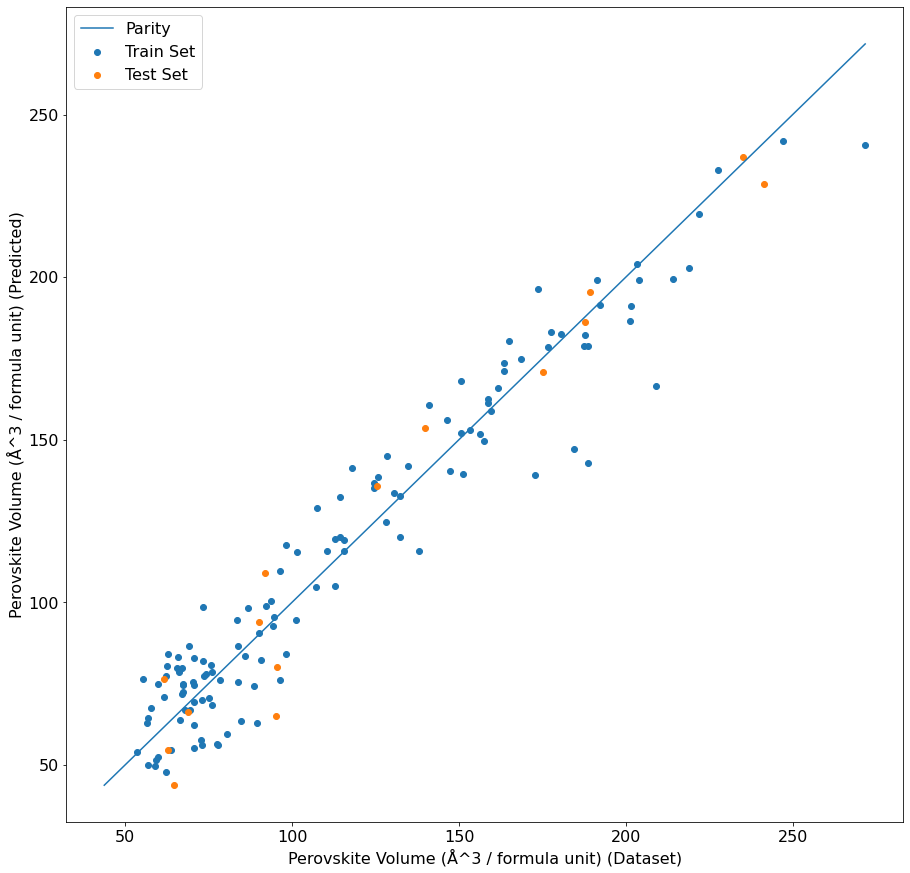

In [45]:
plt.scatter(x=sisso_data_train['Volume'], y=sisso_data_train['r1_1term'], label="Train Set")
plt.scatter(x=sisso_data_test['Volume'], y=sisso_data_test['r1_1term'], label="Test Set")

min_xy = min(min(sisso_data_train['Volume']),
             min(sisso_data_test['Volume']),
             min(sisso_data_train['r1_1term']),
             min(sisso_data_test['r1_1term']))
max_xy = max(max(sisso_data_train['Volume']),
             max(sisso_data_test['Volume']),
             max(sisso_data_train['r1_1term']),
             max(sisso_data_test['r1_1term']))

plt.plot([min_xy, max_xy], [min_xy, max_xy], label="Parity")
plt.ylabel(f"Perovskite Volume (Å^3 / formula unit) (Predicted)")
plt.xlabel(f"Perovskite Volume (Å^3 / formula unit) (Dataset)")
plt.legend()
plt.savefig("sisso_perovskite_volume_parity.jpeg")
plt.show()
plt.close()